In [49]:
# Import relevant libraries and modules
# Data analysis
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
import csv
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Import COVID-19 datasets
states = pd.read_csv('4.18states.csv')
counties = pd.read_csv('abridged_couties.csv')
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

In [74]:
# All titles and numbering correspond directly to those in the report

# III. Exploratory Data Analysis

## i. Data Cleaning

In [51]:
# STEP 1: DATA CLEANING

# Convert abriged_counties.csv data to uniform units
# Columns measured as percentage
percentage_cols = ["Smokers_Percentage", "DiabetesPercentage","MedianAge2010"]
# Columns measured in count per 100,000
per_hun_thousandths = ["HeartDiseaseMortality", "StrokeMortality", "RespMortalityRate2014",'TotalM.D.\'s,TotNon-FedandFed2017'
        ,'#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds']
# Columns measured in total population count
pops = ['PopTotalMale2017','PopTotalFemale2017', 'PopulationEstimate65+2017','#EligibleforMedicare2018'
        ,'MedicareEnrollment,AgedTot2017']

# Remove invalid states and rows without population data
cleaned_counties = counties.copy()
cleaned_counties = cleaned_counties[cleaned_counties.STATEFP.isna()==0]
cleaned_counties = cleaned_counties[cleaned_counties['PopulationEstimate2018'].isna()==0]

# Convert all columns to total population count
for col in percentage_cols:
    cleaned_counties[col] = cleaned_counties["PopulationEstimate2018"] * cleaned_counties[col]
for col in per_hun_thousandths:
    cleaned_counties[col] = cleaned_counties["PopulationEstimate2018"]/(100000) * cleaned_counties[col]


# List of features measured in gregorian time
gregorians = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym']

# Create a data frame grouping features by state and filling NA values for dates with latest day possible
# Taking the latest available gregorian time and sum of all else
cleaned_counties[gregorians] = cleaned_counties[gregorians].fillna(737533)
gregorian_max = cleaned_counties[gregorians+['StateName']].groupby("StateName").agg(np.mean)
cleaned_counties = cleaned_counties.drop(gregorians, axis = 1)

state_fips = cleaned_counties.groupby("StateName").agg(max).STATEFP
cleaned_counties = cleaned_counties.groupby("StateName").agg(sum)
cleaned_counties = cleaned_counties.join(gregorian_max)
cleaned_counties.STATEFP = state_fips

# Add relevant state data from 4.18states.csv dataset
US_full_data = states[['Province_State','Confirmed','Deaths','Recovered','Testing_Rate','FIPS','Incident_Rate',
       'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Hospitalization_Rate']].merge(
    cleaned_counties,how='left',left_on='FIPS',right_on = 'STATEFP')

# Remove invalid state IDs
US_full_data = US_full_data[US_full_data.STATEFP.isna()==0]


# Select only states in the United States to reduce impact of international factors
states = states[states.Country_Region=='US']

# Convert population counts back to original units, because merge is complete
for col in percentage_cols:
    US_full_data[col] = US_full_data[col]/US_full_data["PopulationEstimate2018"]
for col in per_hun_thousandths:
    US_full_data[col] = US_full_data[col]/(US_full_data['PopulationEstimate2018']/100000)
for col in pops:
    US_full_data[col] = US_full_data[col]*100/US_full_data['PopulationEstimate2018']
    
US_full_data.rename({"HeartDiseaseMortality":"HeartDiseaseMortalityRate","StrokeMortality":"StrokeMortalityRate",
                    'TotalM.D.\'s,TotNon-FedandFed2017':'M.D.\'s, Non-FedandFed2017, per 100k'
                     ,'#HospParticipatinginNetwork2017':'HospsParticipatinginNetwork2017 per 100k'
                     ,'#Hospitals':'Hospitalsper100k','#ICU_beds':'ICU Beds per 100k','PopTotalMale2017':"Percent Male in US 2017",
                    'PopTotalFemale2017':"Percent Female in US 2017",'PopulationEstimate65+2017':'Percent Population over 65 Percent'
                     ,'#EligibleforMedicare2018':'Percent EligibleforMedicare2018'
                     ,'MedicareEnrollment,AgedTot2017':'Percent Enrolled in Medicare, 2017'},axis=1,inplace=True)



## ii. Visualization

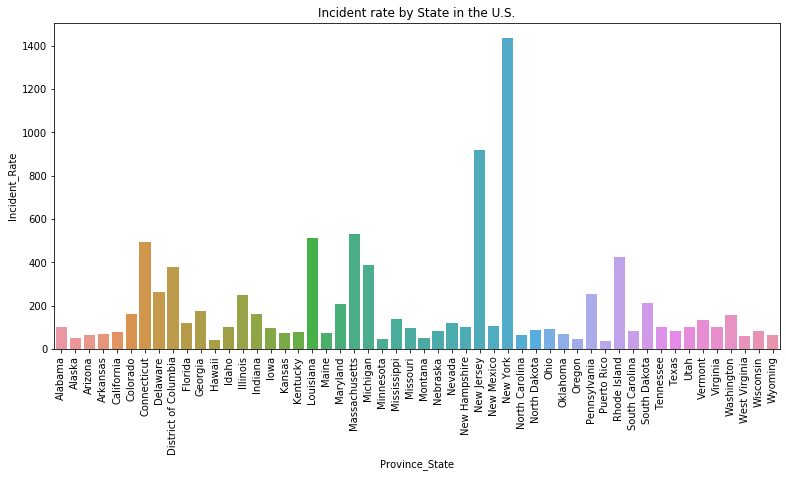

In [52]:
# Create barplot of incident rate by State in the U.S. (Image #1)
fig, ax = plt.subplots(figsize=(13,6))
sns.barplot(x='Province_State',y='Incident_Rate',data=US_full_data)
plt.xticks(rotation='vertical')
plt.title("Incident rate by State in the U.S.");

In [53]:
# Find number of new confirmed cases for each day
states_conf1 = confirmed.groupby('Province_State').sum().drop(columns={'UID','code3','FIPS','Lat','Long_'})
states_conf2 = confirmed.groupby('Province_State').sum().drop(columns={'UID','code3','FIPS','Lat','Long_'})
for i in np.arange(1,len(states_conf1.columns)):
    states_conf2[states_conf1.columns[i]] = states_conf2.iloc[:,i]-states_conf1.iloc[:,(i-1)]


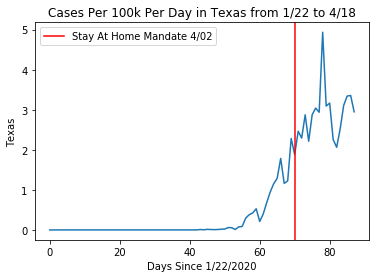

In [54]:
# Plot line graph for cases per 100k in Texas (Image #2)
tx_nums = states_conf2.loc['Texas',:]/290
index = np.arange(0,len(tx_nums))
sns.lineplot(x=index,y=tx_nums)
plt.xlabel('Days Since 1/22/2020')
plt.title('Cases Per 100k Per Day in Texas from 1/22 to 4/18')
plt.axvline(x=70,color='red',label='Stay At Home Mandate 4/02')
plt.legend();

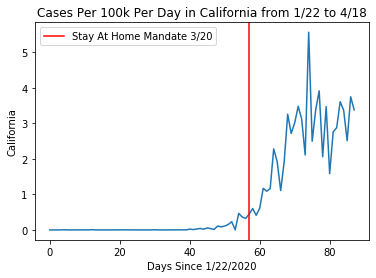

In [55]:
# Plot line graph for cases per 100k in California (Image #3)
ca_nums = states_conf2.loc['California',:]/395
index = np.arange(0,len(ca_nums))
sns.lineplot(x=index,y=ca_nums)
plt.xlabel('Days Since 1/22/2020')
plt.title('Cases Per 100k Per Day in California from 1/22 to 4/18')
plt.axvline(x=57,color='red',label='Stay At Home Mandate 3/20')
plt.legend();

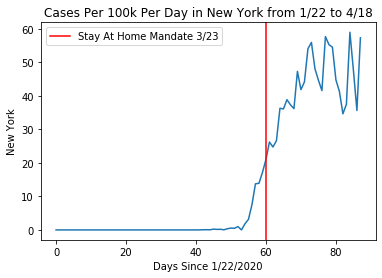

In [56]:
# Plot line graph for cases per 100k in New York(Image #4)
ny_nums = states_conf2.loc['New York',:]/194
index = np.arange(0,len(ny_nums))
sns.lineplot(x=index,y=ny_nums)
plt.xlabel('Days Since 1/22/2020')
plt.title('Cases Per 100k Per Day in New York from 1/22 to 4/18')
plt.axvline(x=60,color='red',label='Stay At Home Mandate 3/23')
plt.legend();

# IV. Feature Selection and Assumptions

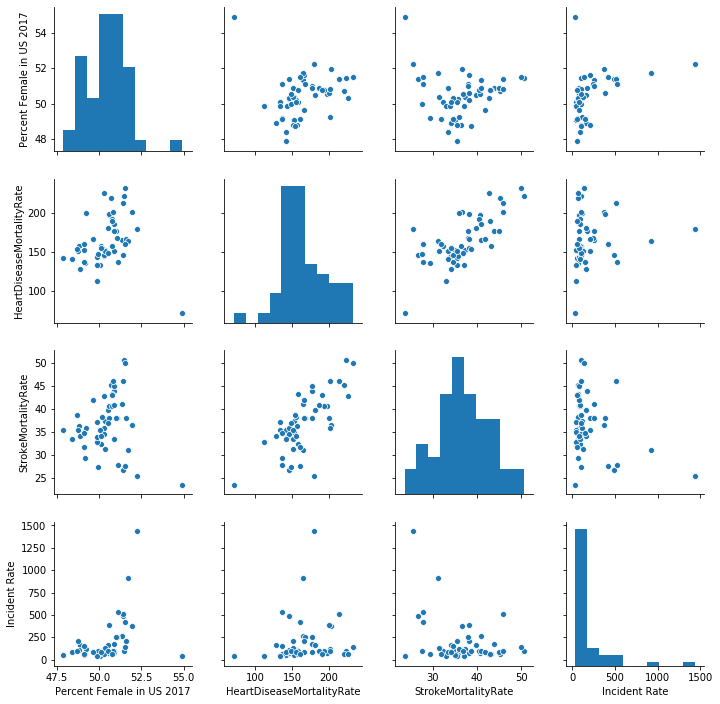

In [57]:
# List of features not to be included in the model
drops = ['FracMale2017','PopulationDensityperSqMile2010','CensusPopulation2010', '3-YrDiabetes2015-17'
         ,'dem_to_rep_ratio','PopMale<52010',
           'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
           'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
           'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
           'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
           'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
           'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
           'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
           'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
           'PopMale>842010', 'PopFmle>842010', '3-YrMortalityAge<1Year2015-17',
           '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
           '3-YrMortalityAge15-24Years2015-17',
           '3-YrMortalityAge25-34Years2015-17',
           '3-YrMortalityAge35-44Years2015-17',
           '3-YrMortalityAge45-54Years2015-17',
           '3-YrMortalityAge55-64Years2015-17',
           '3-YrMortalityAge65-74Years2015-17',
           '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',
         'mortality2015-17Estimated','SVIPercentile', 'HPSAShortage',
       'HPSAServedPop', 'HPSAUnderservedPop','COUNTYFP', 'lat', 'lon'
         ,'POP_LATITUDE', 'POP_LONGITUDE',
       'Rural-UrbanContinuumCode2013', 'FIPS','federal guidelines', 'foreign travel ban', "Percent Male in US 2017"]


US_full_data = US_full_data.drop(drops,axis=1)

# Select features for model that are not directly dependent on variable of interest, Incident_Rate
X = US_full_data.drop({'Province_State', 'Confirmed','Deaths', 'STATEFP','Recovered','People_Tested'
                       ,'People_Hospitalized', 'Mortality_Rate'
                       , 'Hospitalization_Rate','Incident_Rate'},axis=1)

# Select variable of interest in training set for model fitting
Y_incident = US_full_data['Incident_Rate']
Y_mortality = US_full_data['Mortality_Rate']

# Plot pairplot to show relationship between selected features and incident rate (Image 5)
df1 = US_full_data.loc[:,['Percent Female in US 2017',"HeartDiseaseMortalityRate",'StrokeMortalityRate']]
df1['Incident Rate'] = US_full_data['Incident_Rate']
sns.pairplot(df1);


# V. Models

## i. Linear Models

In [58]:
# Create Linear Regression model
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X,Y_incident)

# Define Root Mean Squared Error (RMSE) function
def rmse(model,X,Y):
    return np.sqrt(np.mean((Y-model.predict(X))**2))

# Check RMSE for model on training set
print("Linear Model for Incident Rate RMSE: ", rmse(model_lr,X,Y_incident))

# Compute average cross validation score for Linear Regression model
print("Linear Model for Incident Rate avg. CV MSE score: ", np.mean(cross_val_score(model_lr, X, Y_incident, scoring=rmse, cv=5)))

Linear Model for Incident Rate RMSE:  97.83278011379667
Linear Model for Incident Rate avg. CV MSE score:  261.3361288465761


## ii. Ridge Models

$\textbf{Create Ridge Regression Model on Incident Rate with All Data}$

Ridge Incident Rate RMSE:  109.60354682645414
Ridge Incident Rate avg. CV MSE score:  161.13151046003634
Standard Deviation of Incident Rate: 238.49022851843336


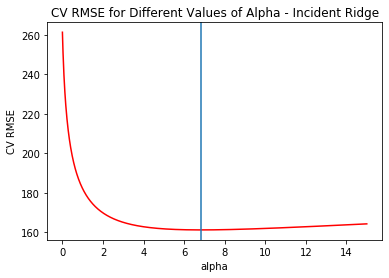

In [59]:
# Initial alpha and possible values
alpha=.1
alpha_arr = np.linspace(0,15, 1000)

# Initialize and import for Ridge

cv_errors_incident_ridge = []
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create pipeline for easy model creation
model_incident_ridge = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha))]) 

# Optimize Ridge alpha by trying array of possible values
for alpha in alpha_arr:
    model_incident_ridge.set_params(LinearModel__alpha=alpha)
    # Compute the cross validation error
    cv_error_incident_ridge = np.mean(cross_val_score(model_incident_ridge, X, Y_incident, scoring=rmse, cv=5))
    cv_errors_incident_ridge.append(cv_error_incident_ridge)

# Identify optimal alpha hyperparameter
best_alpha_incident_ridge = alpha_arr[np.argmin(cv_errors_incident_ridge)]

# Create and fit Ridge model with optimized alpha for data
model_incident_ridge = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha=best_alpha_incident_ridge))]) 
model_incident_ridge.fit(X,Y_incident)


# Check RMSE for model
print("Ridge Incident Rate RMSE: ", rmse(model_incident_ridge,X,Y_incident))

# Compute average cross validation score for Ridge
print("Ridge Incident Rate avg. CV MSE score: ", np.mean(cross_val_score(model_incident_ridge, X, Y_incident, 
                                                                   scoring=rmse, cv=5)))
# Compute standard deviation for incident rate
print("Standard Deviation of Incident Rate:", np.std(Y_incident))

# Create lineplot of RMSE for different values of alpha in the Incident Ridge Model (Image #6)
sns.lineplot(x=alpha_arr,y=cv_errors_incident_ridge,color='red')
plt.xlabel('alpha')
plt.ylabel('CV RMSE')
plt.title('CV RMSE for Different Values of Alpha - Incident Ridge')
plt.axvline(x=alpha_arr[np.argmin(cv_errors_incident_ridge)]);

$\textbf{Create Ridge Regression Model on Incident Rate without NY}$

Ridge Incident Rate No NY RMSE:  104.57976613267155
Ridge Incident Rate No NY avg. CV score:  134.6399072824932
Standard Deviation of Incident Rate: 164.27660609719481


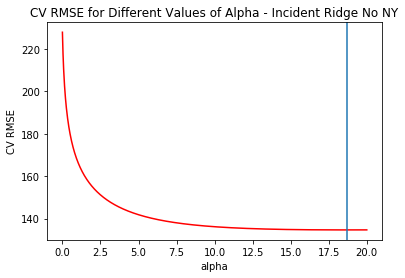

In [60]:
X_no_ny = X.drop(36,axis=0)
Y_no_ny = Y_incident.drop(36,axis=0)

# Initial alpha and possible values
alpha=.1
alpha_arr = np.linspace(0,20, 1000)

# Initialize and import for Ridge
cv_errors_ny = []
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create pipeline for easy model creation
model_ny = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha))]) 

# Optimize Ridge alpha by trying array of possible values
for alpha in alpha_arr:
    model_ny.set_params(LinearModel__alpha=alpha)
    # Compute the cross validation error
    cv_error_ny = np.mean(cross_val_score(model_ny, X_no_ny, Y_no_ny, scoring=rmse, cv=5))
    cv_errors_ny.append(cv_error_ny)

# Identify optimal alpha hyperparameter
best_alpha_ridge_ny = alpha_arr[np.argmin(cv_errors_ny)]

# Create and fit Ridge model with optimized alpha for data without NY value
model_ridge_no_ny = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha=best_alpha_ridge_ny))]) 
model_ridge_no_ny.fit(X_no_ny,Y_no_ny)

# Check RMSE for model without outlier
print("Ridge Incident Rate No NY RMSE: ", rmse(model_ridge_no_ny,X_no_ny,Y_no_ny))

# Compute average cross validation score for Ridge without NY value
print("Ridge Incident Rate No NY avg. CV score: ", np.mean(cross_val_score(model_ridge_no_ny, X_no_ny, Y_no_ny, 
                                                                   scoring=rmse, cv=5)))
# Compute standard deviation for incident rate without NY value
print("Standard Deviation of Incident Rate:", np.std(Y_no_ny))

# Create lineplot of RMSE for different values of alpha in the Incident Ridge Model with No NY (Image #7)
sns.lineplot(x=alpha_arr,y=cv_errors_ny,color='red')
plt.xlabel('alpha')
plt.ylabel('CV RMSE')
plt.title('CV RMSE for Different Values of Alpha - Incident Ridge No NY')
plt.axvline(x=alpha_arr[np.argmin(cv_errors_ny)]);

$\textbf{Ridge Model on Mortality Rate}$

Ridge Mortality Rate RMSE:  1.0316697308848208
Ridge Mortality Rate avg. CV MSE score:  1.4458142842151864
Standard Deviation of Incident Rate: 1.5050291678639263


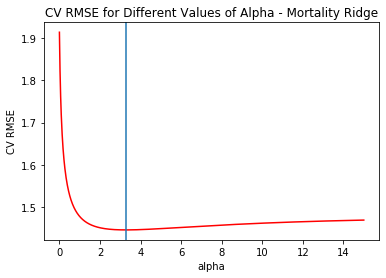

In [61]:
# Initial alpha and possible values
alpha=.1
alpha_arr = np.linspace(0,15, 1000)

# Initialize and import for Ridge

cv_errors_mortality_ridge = []
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create pipeline for easy model creation
model_mortality_ridge = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha))]) 

# Optimize Ridge alpha by trying array of possible values
for alpha in alpha_arr:
    model_mortality_ridge.set_params(LinearModel__alpha=alpha)
    # Compute the cross validation error
    cv_error_mortality_ridge = np.mean(cross_val_score(model_mortality_ridge, X, Y_mortality, scoring=rmse, cv=5))
    cv_errors_mortality_ridge.append(cv_error_mortality_ridge)

# Identify optimal alpha hyperparameter
best_alpha_mortality_ridge = alpha_arr[np.argmin(cv_errors_mortality_ridge)]

# Create and fit Ridge model with optimized alpha for data
model_mortality_ridge = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha=best_alpha_mortality_ridge))]) 
model_mortality_ridge.fit(X,Y_mortality)


# Check RMSE for model without outlier
print("Ridge Mortality Rate RMSE: ", rmse(model_mortality_ridge,X,Y_mortality))

# Compute average cross validation score for Ridge
print("Ridge Mortality Rate avg. CV MSE score: ", np.mean(cross_val_score(model_mortality_ridge, X, Y_mortality, 
                                                                   scoring=rmse, cv=5)))
# Compute standard deviation for mortality rate
print("Standard Deviation of Incident Rate:", np.std(Y_mortality))

# Create lineplot of RMSE for different values of alpha in the Incident Ridge Model with No NY
sns.lineplot(x=alpha_arr,y=cv_errors_mortality_ridge,color='red')
plt.xlabel('alpha')
plt.ylabel('CV RMSE')
plt.title('CV RMSE for Different Values of Alpha - Mortality Ridge')
plt.axvline(x=alpha_arr[np.argmin(cv_errors_mortality_ridge)]);

# VI. Findings and Challenges

$\textbf{Examine Coefficients of All Models}$

In [62]:
# Examining coefficients from the Incident Ridge Model
model_incident_ridge_coeffs = pd.DataFrame(data = {"Coefficient" : model_incident_ridge.named_steps['LinearModel'].coef_, 
                                                   "Absolute Coef": np.abs(model_incident_ridge.named_steps['LinearModel'].coef_),
                                                   "Feature": X.columns}).sort_values(by = "Absolute Coef", ascending = False)
model_incident_ridge_coeffs.drop("Absolute Coef", axis = 1, inplace = True)
model_incident_ridge_coeffs.head()

,Coefficient,Feature
0,100.192222,Testing_Rate
9,-81.546721,StrokeMortalityRate
2,71.793880,Percent Female in US 2017
8,71.043298,HeartDiseaseMortalityRate
12,55.959311,#FTEHospitalTotal2017


In [63]:
# Examining coefficients from the Incident Ridge Model without New York
model_incident_no_ny_ridge_coeffs = pd.DataFrame(data = {"Coefficient" : model_ridge_no_ny.named_steps['LinearModel'].coef_,
                                                        "Absolute Coef": np.abs(model_ridge_no_ny.named_steps['LinearModel'].coef_),
                                                        "Feature": X.columns}).sort_values(by = "Absolute Coef", ascending = False)
model_incident_no_ny_ridge_coeffs.drop("Absolute Coef", axis = 1, inplace = True)
model_incident_no_ny_ridge_coeffs.head()

,Coefficient,Feature
0,53.931713,Testing_Rate
2,47.418138,Percent Female in US 2017
8,35.250767,HeartDiseaseMortalityRate
9,-26.690973,StrokeMortalityRate
4,19.807614,MedianAge2010


In [64]:
# Examining coefficients from the Mortality Ridge Model 
model_mortality_ridge_coeffs = pd.DataFrame(data = {"Coefficient" : model_mortality_ridge.named_steps['LinearModel'].coef_,
                                                    "Absolute Coef": np.abs(model_mortality_ridge.named_steps['LinearModel'].coef_),
                                                    "Feature": X.columns}).sort_values(by = "Absolute Coef", ascending = False)
model_mortality_ridge_coeffs.drop("Absolute Coef", axis = 1, inplace = True)
model_mortality_ridge_coeffs.head()

,Coefficient,Feature
2,0.610958,Percent Female in US 2017
9,-0.539029,StrokeMortalityRate
8,0.506433,HeartDiseaseMortalityRate
17,-0.492911,stay at home
14,0.492367,HospsParticipatinginNetwork2017 per 100k


$\textbf{Compare Absolute Coefficients for Incident and Mortality Rate Ridge Regressions}$

In [65]:
def normalize(X):
    return (X-np.mean(X))/np.std(X)
Y_incident_normal = normalize(Y_incident)
Y_mortality_normal = normalize(Y_mortality)

# Initial alpha and possible values
alpha=.1
alpha_arr = np.linspace(0,15, 1000)

# Initialize and import for Ridge

cv_errors_incident_ridge_normal = []
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create pipeline for easy model creation
model_incident_ridge_normal = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha))]) 

# Optimize Ridge alpha by trying array of possible values
for alpha in alpha_arr:
    model_incident_ridge_normal.set_params(LinearModel__alpha=alpha)
    # Compute the cross validation error
    cv_error_incident_ridge_normal = np.mean(cross_val_score(model_incident_ridge_normal, X, Y_incident_normal, scoring=rmse, cv=5))
    cv_errors_incident_ridge_normal.append(cv_error_incident_ridge_normal)

# Identify optimal alpha hyperparameter
best_alpha_incident_ridge_normal = alpha_arr[np.argmin(cv_errors_incident_ridge_normal)]

# Create and fit Ridge model with optimized alpha for Normalized Data for Incident Rate
model_incident_ridge_normal = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha=best_alpha_incident_ridge_normal))]) 
model_incident_ridge_normal.fit(X,Y_incident_normal)

# Initial alpha and possible values
alpha=.1
alpha_arr = np.linspace(0,15, 1000)

# Initialize and import for Ridge

cv_errors_mortality_ridge_normal = []
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Create pipeline for easy model creation
model_mortality_ridge_normal = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha))]) 

# Optimize Ridge alpha by trying array of possible values
for alpha in alpha_arr:
    model_mortality_ridge_normal.set_params(LinearModel__alpha=alpha)
    # Compute the cross validation error
    cv_error_mortality_ridge_normal = np.mean(cross_val_score(model_mortality_ridge_normal, X, Y_mortality_normal, scoring=rmse, cv=5))
    cv_errors_mortality_ridge_normal.append(cv_error_mortality_ridge_normal)

# Identify optimal alpha hyperparameter
best_alpha_mortality_ridge_normal= alpha_arr[np.argmin(cv_errors_mortality_ridge_normal)]

# Create and fit Ridge model with optimized alpha for Normalized data for Mortality Rate
model_mortality_ridge_normal = Pipeline([('transformer', StandardScaler()),
                 ('LinearModel',Ridge(alpha=best_alpha_mortality_ridge_normal))]) 
model_mortality_ridge_normal.fit(X,Y_mortality_normal);

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


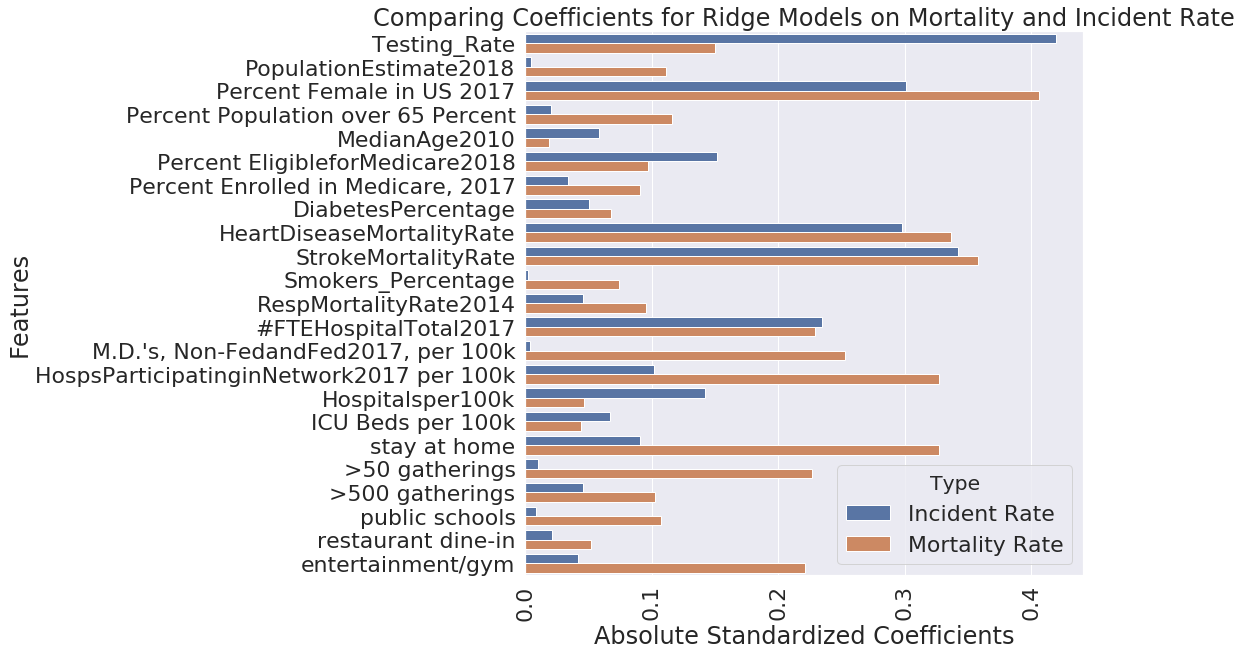

In [75]:
# Visualizing the Differences between Coefficients (Image #8)
all_coefs = list(np.abs(model_incident_ridge_normal.named_steps['LinearModel'].coef_))+list(np.abs(model_mortality_ridge_normal.named_steps['LinearModel'].coef_))
barplot_ridge = pd.DataFrame(all_coefs)

barplot_ridge.rename({0:'Absolute Standardized Coefficients'},axis=1,inplace=True)
barplot_ridge['Features']=list(X.columns)+list(X.columns)

barplot_ridge['Type']=np.linspace(0,0,46)
barplot_ridge['Type'][np.arange(0,23)]=np.linspace(1,1,23)
types = []
for i in barplot_ridge['Type']:
    if i==1:
        types+=['Incident Rate']
    else:
        types+=['Mortality Rate']

barplot_ridge['Type'] = types
plt.figure(figsize=(10,10))
sns.barplot(y='Features',x='Absolute Standardized Coefficients',hue='Type',data=barplot_ridge)
plt.xticks(rotation='vertical')
plt.title('Comparing Coefficients for Ridge Models on Mortality and Incident Rate');

$\textbf{Display Higher Median Age's Impact on Incident Rate Predictions}$

Text(0, 0.5, 'Incident Rate Predictions')

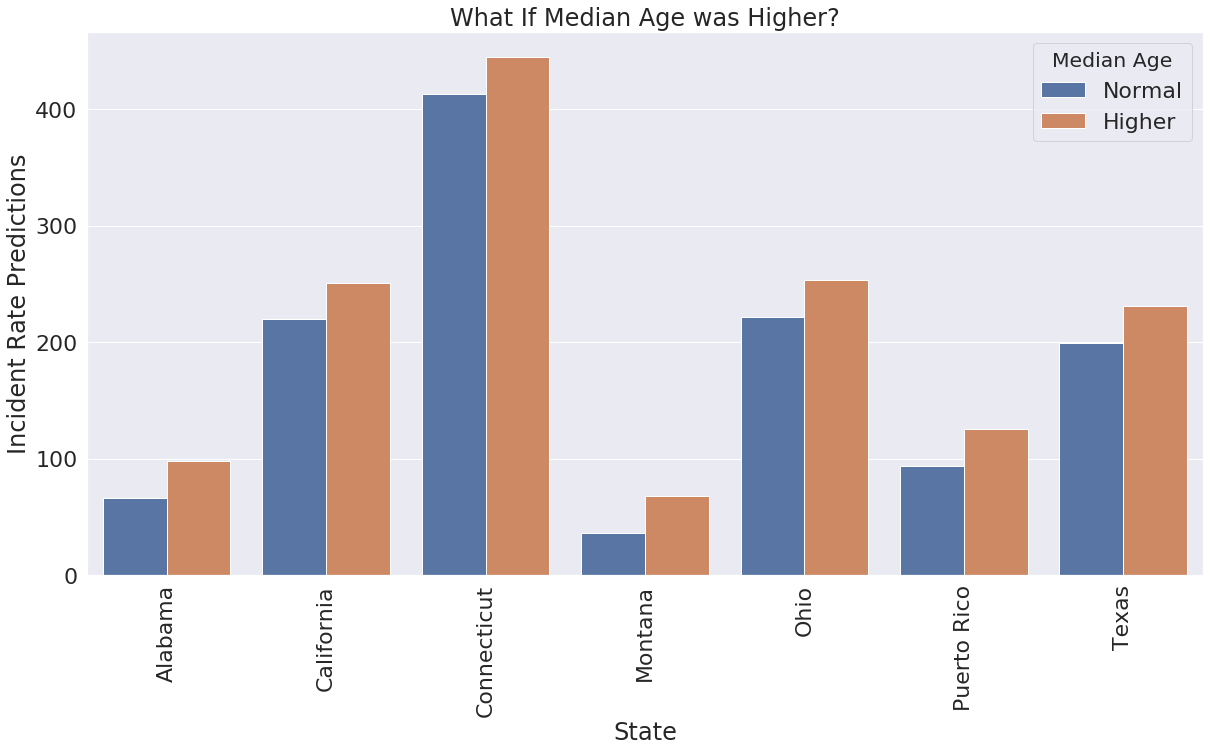

In [71]:
# Create barplot to show higher median age impact (Image #9)
X_higher_med_age = X.copy()
X_higher_med_age["MedianAge2010"] = X["MedianAge2010"] + 5
regular_pred = model_incident_ridge.predict(X)
higher_med_age_pred = model_incident_ridge.predict(X_higher_med_age)
d = {'Predictions': np.append(np.array(regular_pred), np.array(higher_med_age_pred)), 
     "State": np.append(np.array(US_full_data["Province_State"]), np.array(US_full_data["Province_State"])),
    "Median Age": np.append(np.zeros(52), np.ones(52))}
diff_med_ages = pd.DataFrame(data = d)
diff_med_ages["Median Age"] = diff_med_ages["Median Age"].replace(0, "Normal").replace(1, "Higher")
diff_med_ages = diff_med_ages[diff_med_ages["State"].isin(["Alabama", "California", "Connecticut", "Texas", "Montana", "Ohio", "Puerto Rico"])]
plt.figure(figsize = (20,10))
sns.set(font_scale = 2)
sns.barplot(x = "State", y = "Predictions", hue = "Median Age", data = diff_med_ages)
plt.xticks(rotation='vertical')
plt.title("What If Median Age was Higher?")
plt.ylabel("Incident Rate Predictions")

$\textbf{Display More Hospitals Per 100k's Impact on Mortality Rate Predictions}$

Text(0, 0.5, 'Mortality Rate Predictions')

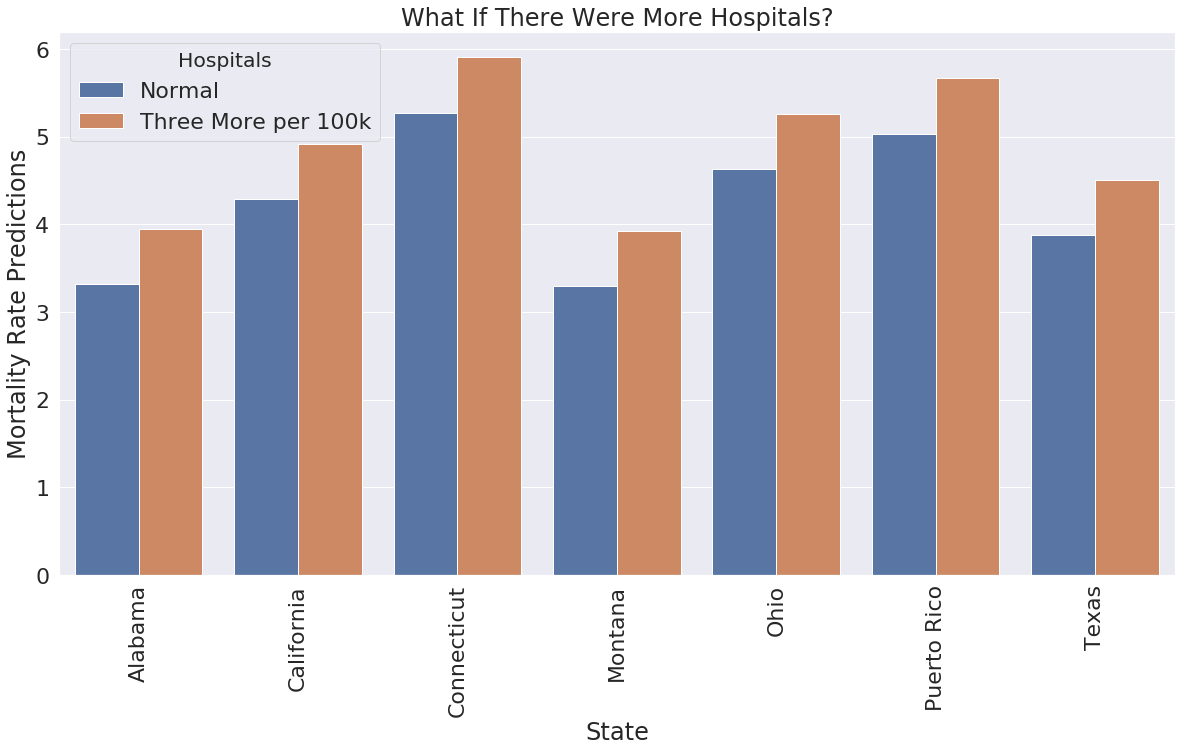

In [76]:
# Create barplot to show more hospitals per 100k impact (Image #10)
X_more_hosp = X.copy()
X_more_hosp["HospsParticipatinginNetwork2017 per 100k"] = X["HospsParticipatinginNetwork2017 per 100k"] + 3
regular_pred = model_mortality_ridge.predict(X)
more_hosp_pred = model_mortality_ridge.predict(X_more_hosp)
d = {'Predictions': np.append(np.array(regular_pred), np.array(more_hosp_pred)), 
     "State": np.append(np.array(US_full_data["Province_State"]), np.array(US_full_data["Province_State"])),
    "Hospitals": np.append(np.zeros(52), np.ones(52))}
diff_num_hospitals = pd.DataFrame(data = d)
diff_num_hospitals["Hospitals"] = diff_num_hospitals["Hospitals"].replace(0, "Normal").replace(1, "Three More per 100k")
diff_num_hospitals = diff_num_hospitals[diff_num_hospitals["State"].isin(["Alabama", "California", "Connecticut", "Texas", "Montana", "Ohio", "Puerto Rico"])]
plt.figure(figsize = (20,10))
sns.set(font_scale = 2)
sns.barplot(x = "State", y = "Predictions", hue = "Hospitals", data = diff_num_hospitals)
plt.xticks(rotation='vertical')
plt.title("What If There Were More Hospitals?")
plt.ylabel("Mortality Rate Predictions")